#### This document is for analysis on FACT-E emotional well being (EWB).

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import re

# Preliminary

In [56]:
# Read the CSV file - linked file 
file_path = "Merged_TSQIC_REDCap_ACCESS.xlsx" 
df = pd.read_excel(file_path)
df

,id,operation_date,redcap_event_name,dob,qol_date,age_diagnosis,gender,overall_primary_tumour,overall_regional_ln,overall_distant_metastasis,...,ge1,ge2,ge3,ge4,ge5,ge6,readmission_30d,postop_comp,los,DischargeDate
0,1,NaT,baseline_arm_1,2049-08-04,NaT,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,2012-04-27
1,1,2011-08-26,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-08-26
2,1,2010-02-20,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,2010-03-08
3,1,2009-02-25,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,2009-03-05
4,1,2008-02-22,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,2008-03-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13103,1770,NaT,preoperative_arm_1,NaT,2025-02-24,NaN,NaN,NaN,NaN,NaN,...,2.0,3.0,0.0,3.0,2.0,2.0,NaN,NaN,NaN,NaT
13104,1770,NaT,preoperative_arm_1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
13105,1770,NaT,preoperative_arm_1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
13106,1770,NaT,baseline_arm_1,NaT,NaT,42.054252,NaN,3,0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [73]:
df['id'].nunique()

1754

In [58]:
# Step 1: Filter rows where redcap_event_name is either "baseline_arm_1" or "preoperative_arm_1"
filtered_df = df[df['redcap_event_name'].isin(["baseline_arm_1", "preoperative_arm_1"])]

# Step 2: Check if each id has both events
event_counts = filtered_df.groupby('id')['redcap_event_name'].nunique()
valid_ids = event_counts[event_counts == 2].index  # Keep only IDs with both events

# Step 3: Ensure all six columns have values (non-null) for these IDs
valid_rows = filtered_df[filtered_df['id'].isin(valid_ids)]
valid_rows = valid_rows.dropna(subset=["ge1", "ge2", "ge3", "ge4", "ge5", "ge6"])

# Step 4: Find IDs that still have both events after removing rows with NaNs
final_ids = valid_rows.groupby('id')['redcap_event_name'].nunique()
final_ids = final_ids[final_ids == 2].index

len(final_ids)


264

In [59]:
# Step 1: Filter relevant rows
filtered_df = df[df['redcap_event_name'].isin(["baseline_arm_1", "preoperative_arm_1", "1_year_postop_arm_1"])]

# Step 2: Ensure each id has required event pairs
event_counts = filtered_df.groupby('id')['redcap_event_name'].apply(set)

# Step 3: Find ids that have the required event pairs
valid_ids = event_counts[event_counts.apply(lambda x: {"baseline_arm_1", "1_year_postop_arm_1"}.issubset(x) or 
                                                        {"preoperative_arm_1", "1_year_postop_arm_1"}.issubset(x))].index

# Step 4: Check if all six columns have non-null values
valid_rows = filtered_df[filtered_df['id'].isin(valid_ids)]
valid_rows = valid_rows.dropna(subset=["ge1", "ge2", "ge3", "ge4", "ge5", "ge6"])

# Step 5: Reconfirm ids still have required event pairs after removing NaNs
final_event_counts = valid_rows.groupby('id')['redcap_event_name'].apply(set)
final_ids = final_event_counts[final_event_counts.apply(lambda x: {"baseline_arm_1", "1_year_postop_arm_1"}.issubset(x) or 
                                                                {"preoperative_arm_1", "1_year_postop_arm_1"}.issubset(x))].index

len(final_ids)


127

In [60]:
# Assuming your dataframe is called 'df' and the ID column is called 'id'
# If your ID column has a different name, replace 'id' with the actual column name

# Step 1: Find IDs that match each condition
# Group by ID and check which events are present
event_groups = df.groupby('id')['redcap_event_name'].unique()

# Condition 1: Has both "baseline_arm_1" and "1_year_postop_arm_1"
cond1_ids = event_groups[
    event_groups.apply(lambda x: all(event in x for event in ["baseline_arm_1", "1_year_postop_arm_1"]))
].index

# Condition 2: Has both "preoperative_arm_1" and "1_year_postop_arm_1"
cond2_ids = event_groups[
    event_groups.apply(lambda x: all(event in x for event in ["preoperative_arm_1", "1_year_postop_arm_1"]))
].index

# Condition 3: Has all three events
cond3_ids = event_groups[
    event_groups.apply(lambda x: all(event in x for event in ["baseline_arm_1", "preoperative_arm_1", "1_year_postop_arm_1"]))
].index

# Combine all matching IDs (using set to avoid duplicates)
matching_ids = set(cond1_ids).union(cond2_ids).union(cond3_ids)

# Step 2: Subset the original dataframe
filtered_df = df[df['id'].isin(matching_ids)]

# See how many unique IDs were found
print(f"Number of matching IDs: {len(matching_ids)}")

# See which events are present in the filtered data
print(filtered_df.groupby('id')['redcap_event_name'].unique())

Number of matching IDs: 189
id
32      [baseline_arm_1, surgery_arm_1, 1_year_postop_...
76      [baseline_arm_1, surgery_arm_1, preoperative_a...
125     [baseline_arm_1, surgery_arm_1, preoperative_a...
151     [surgery_arm_1, baseline_arm_1, preoperative_a...
160     [baseline_arm_1, surgery_arm_1, preoperative_a...
                              ...                        
1590    [1_year_postop_arm_1, surgery_arm_1, preoperat...
1615    [surgery_arm_1, baseline_arm_1, preoperative_a...
1621    [1_year_postop_arm_1, baseline_arm_1, preopera...
1648    [surgery_arm_1, 1_year_postop_arm_1, preoperat...
1664    [1_year_postop_arm_1, surgery_arm_1, baseline_...
Name: redcap_event_name, Length: 189, dtype: object


In [71]:
import pandas as pd

# Assuming df is your dataframe with 'id', 'redcap_event_name', and 'ge1' to 'ge6' columns
score_cols = ['ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']

# Step 1: Filter IDs with required redcap_event_name combinations
id_events = df.groupby('id')['redcap_event_name'].unique().reset_index()
def has_required_events(events):
    events_set = set(events)
    baseline = "baseline_arm_1" in events_set
    preop = "preoperative_arm_1" in events_set
    postop = "1_year_postop_arm_1" in events_set
    return (baseline and postop) or (preop and postop) or (baseline and preop and postop)

valid_ids = id_events[id_events['redcap_event_name'].apply(has_required_events)]['id']
df_filtered = df[df['id'].isin(valid_ids)]

# Step 2: Filter IDs with at least one ge1-ge6 score in the required events
def check_scores_per_id(id_df):
    events = id_df['redcap_event_name'].unique()
    baseline = "baseline_arm_1" in events
    preop = "preoperative_arm_1" in events
    postop = "1_year_postop_arm_1" in events
    has_scores = lambda df: df[score_cols].notna().any().any()
    
    baseline_df = id_df[id_df['redcap_event_name'] == "baseline_arm_1"]
    preop_df = id_df[id_df['redcap_event_name'] == "preoperative_arm_1"]
    postop_df = id_df[id_df['redcap_event_name'] == "1_year_postop_arm_1"]
    
    if baseline and postop:
        if has_scores(baseline_df) and has_scores(postop_df):
            return True
    if preop and postop:
        if has_scores(preop_df) and has_scores(postop_df):
            return True
    if baseline and preop and postop:
        if has_scores(baseline_df) and has_scores(preop_df) and has_scores(postop_df):
            return True
    return False

id_groups = df_filtered.groupby('id')
valid_ids_with_scores = id_groups.filter(check_scores_per_id)['id'].unique()

# Output the result
print("IDs with required events and at least one ge1-ge6 score:", len(valid_ids_with_scores.tolist()))

IDs with required events and at least one ge1-ge6 score: 136


# Analysis

In [66]:

# Step 1: Find eligible IDs (those with the required combinations of visits)
def find_eligible_ids(df):
    # Get unique IDs and their associated event names
    id_events = df.groupby('id')['redcap_event_name'].apply(set)
    
    eligible_ids = []
    for id_val, events in id_events.items():
        # Check if ID has (baseline + 1-year) OR (preoperative + 1-year) OR all three
        has_baseline = "baseline_arm_1" in events
        has_preop = "preoperative_arm_1" in events
        has_one_year = "1_year_postop_arm_1" in events
        
        if (has_baseline and has_one_year) or (has_preop and has_one_year):
            eligible_ids.append(id_val)
    
    return eligible_ids

# Step 2: Filter dataset to include only eligible IDs
def filter_eligible_data(df, eligible_ids):
    return df[df['id'].isin(eligible_ids)].copy()

# Step 3: Calculate individual GE scores
def process_ge_score(x, reverse=True):
    if pd.isna(x):
        return np.nan
    try:
        x = pd.to_numeric(x)
        if isinstance(x, list):
            return [4 - val if reverse else val for val in x]
        return 4 - x if reverse else x
    except:
        return np.nan

def calculate_ge_scores(df):
    for col, reverse in [
        ("ge1", True), 
        ("ge2", False), 
        ("ge3", True), 
        ("ge4", True), 
        ("ge5", True), 
        ("ge6", True)
    ]:
        if col in df.columns:
            df.loc[:, f"{col}_score"] = df[col].apply(lambda x: process_ge_score(x, reverse=reverse))
        else:
            print(f"Warning: Column {col} not found in dataframe")
    return df

# Step 4: Calculate FACT-E score for each ID and visit
def calculate_fact_e_score(df):
    ge_score_cols = [col for col in df.columns if col.startswith('ge') and col.endswith('_score')]
    
    if not ge_score_cols:
        print("Warning: No ge_score columns found. Check column names.")
        return df
    
    df.loc[:, 'sum_ge_scores'] = df[ge_score_cols].sum(axis=1, skipna=True)
    df.loc[:, 'count_ge_items'] = df[ge_score_cols].notna().sum(axis=1)
    
    df.loc[:, 'fact_e_score'] = np.where(
        df['count_ge_items'] > 0,
        (df['sum_ge_scores'] * 6) / df['count_ge_items'],
        np.nan
    )
    
    return df

# Step 5: Analyze improvement for each eligible ID
def analyze_improvement(df):
    results = []
    unique_ids = df['id'].unique()
    print(f"Analyzing {len(unique_ids)} unique IDs")
    
    for id_val in unique_ids:
        id_data = df[df['id'] == id_val]
        
        # Debug: Print event types for this ID
        events = id_data['redcap_event_name'].unique()
        print(f"ID {id_val} has events: {events}")
        
        # Group by event type and calculate average fact_e_score for each event type
        event_scores = id_data.groupby('redcap_event_name').agg({
            'fact_e_score': 'mean'  # Average the fact_e_score for duplicate events
        }).reset_index()
        
        # Extract scores for each visit type
        baseline_score = event_scores[event_scores['redcap_event_name'] == 'baseline_arm_1']['fact_e_score'].values
        preop_score = event_scores[event_scores['redcap_event_name'] == 'preoperative_arm_1']['fact_e_score'].values
        one_year_score = event_scores[event_scores['redcap_event_name'] == '1_year_postop_arm_1']['fact_e_score'].values
        
        # Debug: Print whether we found data for each visit type
        print(f"  Baseline score: {baseline_score}")
        print(f"  Preop score: {preop_score}")
        print(f"  One-year score: {one_year_score}")
        
        # Skip if no 1-year data
        if len(one_year_score) == 0 or pd.isna(one_year_score[0]):
            print(f"  Skipping ID {id_val}: No valid one-year score")
            continue
        
        one_year_score = one_year_score[0]
        
        # Determine which baseline to use (baseline_arm_1 preferred)
        baseline_type = None
        baseline_value = None
        
        if len(baseline_score) > 0 and not pd.isna(baseline_score[0]):
            baseline_value = baseline_score[0]
            baseline_type = 'baseline_arm_1'
            print(f"  Using baseline score: {baseline_value}")
        
        if baseline_value is None and len(preop_score) > 0 and not pd.isna(preop_score[0]):
            baseline_value = preop_score[0]
            baseline_type = 'preoperative_arm_1'
            print(f"  Using preop score as baseline: {baseline_value}")
        
        if baseline_value is None:
            print(f"  Skipping ID {id_val}: No valid baseline score")
            continue
        
        # Calculate improvement
        improvement = one_year_score - baseline_value
        has_improved = improvement >= 5
        
        results.append({
            'id': id_val,
            'baseline_type': baseline_type,
            'baseline_score': baseline_value,
            'one_year_score': one_year_score,
            'improvement': improvement,
            'has_improved': has_improved
        })
    
    return pd.DataFrame(results)

# Main function to run the entire analysis
def analyze_patient_outcomes(df):
    # Check for required columns
    required_columns = ['id', 'redcap_event_name', 'ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"Warning: Missing required columns: {missing_columns}")
    
    # Step 1 & 2: Find eligible IDs and filter data
    eligible_ids = find_eligible_ids(df)
    print(f"Found {len(eligible_ids)} eligible IDs")
    
    filtered_df = filter_eligible_data(df, eligible_ids)
    print(f"Filtered dataframe shape: {filtered_df.shape}")
    
    # Step 3: Calculate individual GE scores
    filtered_df = calculate_ge_scores(filtered_df)
    
    # Debug: Check if GE score columns were created
    ge_score_cols = [col for col in filtered_df.columns if col.endswith('_score')]
    print(f"Created score columns: {ge_score_cols}")
    
    # Step 4: Calculate FACT-E score
    filtered_df = calculate_fact_e_score(filtered_df)
    
    # Debug: Check how many FACT-E scores are non-NaN
    if 'fact_e_score' in filtered_df.columns:
        non_nan_scores = filtered_df['fact_e_score'].notna().sum()
        print(f"Non-NaN FACT-E scores: {non_nan_scores} out of {len(filtered_df)}")
    
    # Step 5: Analyze improvement
    results_df = analyze_improvement(filtered_df)
    
    # Summary statistics
    total_patients = len(results_df)
    if total_patients > 0:
        improved_patients = results_df['has_improved'].sum()
        improvement_rate = improved_patients / total_patients * 100
        
        print(f"\nAnalysis complete for {total_patients} patients")
        print(f"Patients with improvement (≥5 points): {improved_patients} ({improvement_rate:.1f}%)")
    else:
        print("\nNo valid patient outcomes could be analyzed.")
    
    return filtered_df, results_df

# Example usage:
filtered_df, results_df = analyze_patient_outcomes(df)
results_df

Found 189 eligible IDs
Filtered dataframe shape: (2340, 31)
Created score columns: ['ge1_score', 'ge2_score', 'ge3_score', 'ge4_score', 'ge5_score', 'ge6_score']
Non-NaN FACT-E scores: 446 out of 2340
Analyzing 189 unique IDs
ID 32 has events: ['baseline_arm_1' 'surgery_arm_1' '1_year_postop_arm_1'
 'preoperative_arm_1']
  Baseline score: [6.]
  Preop score: [nan]
  One-year score: [24.]
  Using baseline score: 6.0
ID 76 has events: ['baseline_arm_1' 'surgery_arm_1' 'preoperative_arm_1'
 '1_year_postop_arm_1']
  Baseline score: [nan]
  Preop score: [14.]
  One-year score: [11.]
  Using preop score as baseline: 14.0
ID 125 has events: ['baseline_arm_1' 'surgery_arm_1' 'preoperative_arm_1'
 '1_year_postop_arm_1']
  Baseline score: [21.]
  Preop score: [16.]
  One-year score: [19.]
  Using baseline score: 21.0
ID 151 has events: ['surgery_arm_1' 'baseline_arm_1' 'preoperative_arm_1'
 '1_year_postop_arm_1']
  Baseline score: [nan]
  Preop score: [nan]
  One-year score: [nan]
  Skipping ID 

,id,baseline_type,baseline_score,one_year_score,improvement,has_improved
0,32,baseline_arm_1,6.0,24.0,18.0,True
1,76,preoperative_arm_1,14.0,11.0,-3.0,False
2,125,baseline_arm_1,21.0,19.0,-2.0,False
3,160,baseline_arm_1,21.0,23.0,2.0,False
4,198,baseline_arm_1,17.0,23.0,6.0,True
...,...,...,...,...,...,...
131,1571,baseline_arm_1,16.0,15.0,-1.0,False
132,1572,baseline_arm_1,19.0,18.0,-1.0,False
133,1615,baseline_arm_1,16.0,20.0,4.0,False
134,1621,baseline_arm_1,14.0,20.0,6.0,True


In [77]:
df[df['id']==525][['id', 'redcap_event_name', 'ge1', 'ge2', 'ge3', 'ge4', 'ge5', 'ge6']]

,id,redcap_event_name,ge1,ge2,ge3,ge4,ge5,ge6
4365,525,surgery_arm_1,NaN,NaN,NaN,NaN,NaN,NaN
4366,525,surgery_arm_1,NaN,NaN,NaN,NaN,NaN,NaN
4367,525,surgery_arm_1,NaN,NaN,NaN,NaN,NaN,NaN
4368,525,preoperative_arm_1,NaN,NaN,NaN,NaN,NaN,NaN
4369,525,preoperative_arm_1,1.0,3.0,2.0,3.0,1.0,2.0
4370,525,baseline_arm_1,3.0,0.0,4.0,3.0,1.0,3.0
4371,525,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN
4372,525,baseline_arm_1,NaN,NaN,NaN,NaN,NaN,NaN
4373,525,1_year_postop_arm_1,NaN,NaN,NaN,NaN,NaN,NaN
4374,525,preoperative_arm_1,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
filtered_df

,id,operation_date,redcap_event_name,dob,qol_date,age_diagnosis,gender,overall_primary_tumour,overall_regional_ln,overall_distant_metastasis,...,DischargeDate,ge1_score,ge2_score,ge3_score,ge4_score,ge5_score,ge6_score,sum_ge_scores,count_ge_items,fact_e_score
243,32,NaT,baseline_arm_1,1977-09-24,NaT,NaN,1.0,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
244,32,2007-11-15,surgery_arm_1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,2007-11-30,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
245,32,NaT,baseline_arm_1,NaT,NaT,29.722718,NaN,3,0,0.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
246,32,NaT,1_year_postop_arm_1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
247,32,NaT,preoperative_arm_1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12545,1664,NaT,baseline_arm_1,NaT,NaT,71.453897,NaN,3,1,0.0,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
12546,1664,NaT,surgery_arm_1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
12547,1664,NaT,1_year_postop_arm_1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN
12548,1664,NaT,preoperative_arm_1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN


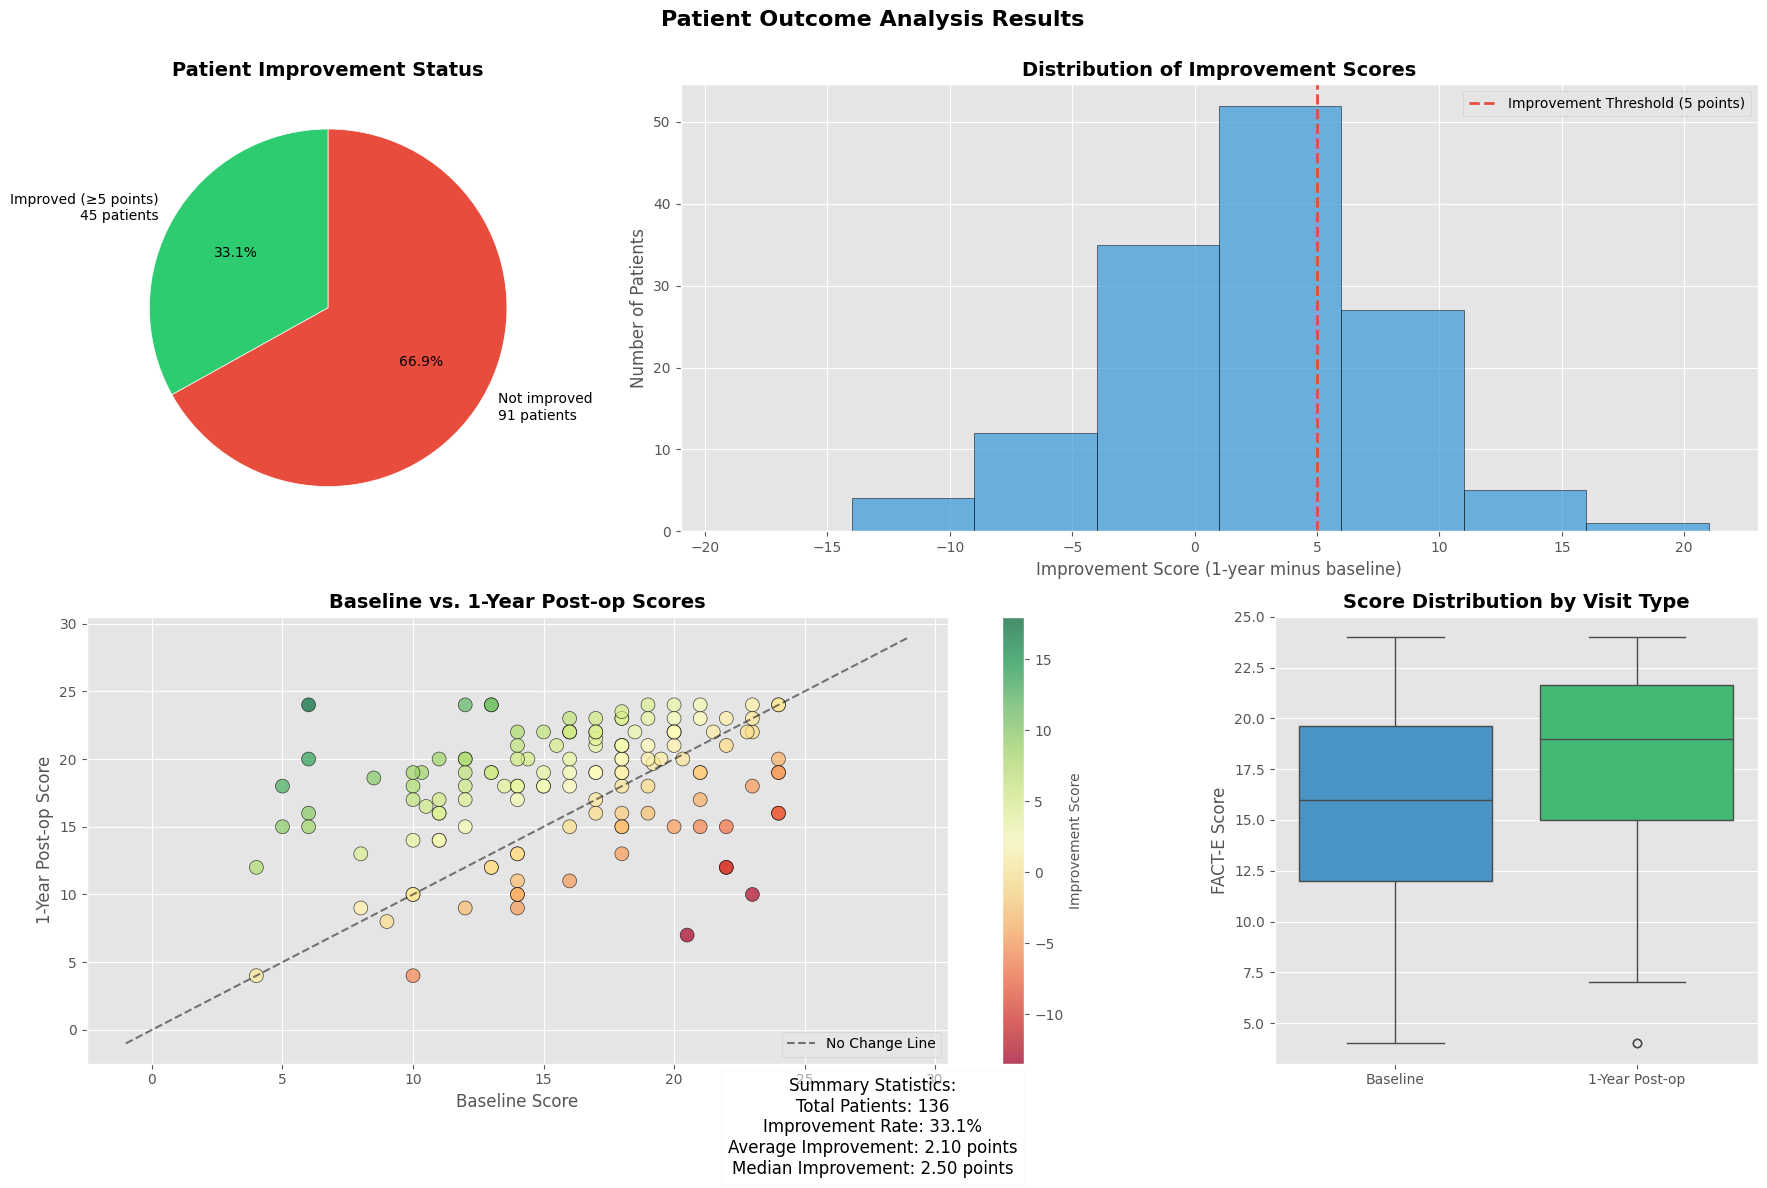

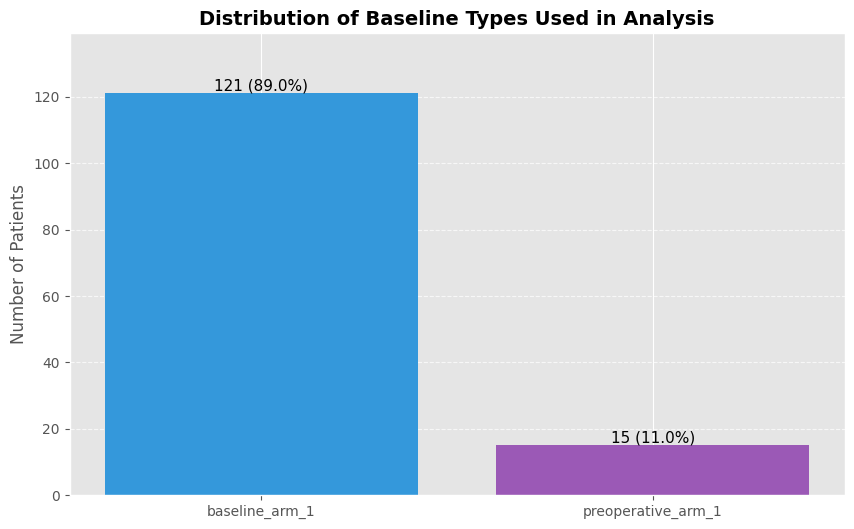

In [ ]:

# Assuming results_df is available from the previous analysis
# If you need to recreate it, uncomment and run the code block below:
# filtered_df, results_df = analyze_patient_outcomes(df)

# Set the style
plt.style.use('ggplot')
sns.set_palette("colorblind")

# Create a figure with multiple subplots
fig = plt.figure(figsize=(18, 12))

# 1. Pie chart showing percentage of patients who improved vs. didn't improve
ax1 = plt.subplot2grid((2, 3), (0, 0))
improved_count = results_df['has_improved'].sum()
not_improved_count = len(results_df) - improved_count
improvement_data = [improved_count, not_improved_count]
labels = [f'Improved (≥5 points)\n{improved_count} patients', f'Not improved\n{not_improved_count} patients']
colors = ['#2ecc71', '#e74c3c']
ax1.pie(improvement_data, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops={'edgecolor': 'white'})
ax1.set_title('Patient Improvement Status', fontsize=14, fontweight='bold')

# 2. Bar chart showing the distribution of improvement scores
ax2 = plt.subplot2grid((2, 3), (0, 1), colspan=2)
bins = np.arange(np.floor(results_df['improvement'].min()) - 5, 
                np.ceil(results_df['improvement'].max()) + 5, 5)
ax2.hist(results_df['improvement'], bins=bins, color='#3498db', alpha=0.7, edgecolor='black')
ax2.axvline(x=5, color='#e74c3c', linestyle='--', linewidth=2, label='Improvement Threshold (5 points)')
ax2.set_xlabel('Improvement Score (1-year minus baseline)', fontsize=12)
ax2.set_ylabel('Number of Patients', fontsize=12)
ax2.set_title('Distribution of Improvement Scores', fontsize=14, fontweight='bold')
ax2.legend()

# 3. Scatter plot of baseline vs one-year scores
ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
scatter = ax3.scatter(results_df['baseline_score'], results_df['one_year_score'], 
                     c=results_df['improvement'], cmap='RdYlGn', s=100, alpha=0.7, edgecolor='black')
# Add a diagonal line representing no change
min_val = min(results_df['baseline_score'].min(), results_df['one_year_score'].min()) - 5
max_val = max(results_df['baseline_score'].max(), results_df['one_year_score'].max()) + 5
ax3.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='No Change Line')
ax3.set_xlabel('Baseline Score', fontsize=12)
ax3.set_ylabel('1-Year Post-op Score', fontsize=12)
ax3.set_title('Baseline vs. 1-Year Post-op Scores', fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax3)
cbar.set_label('Improvement Score', fontsize=10)
ax3.legend(loc='lower right')

# 4. Box plot of scores by visit type
ax4 = plt.subplot2grid((2, 3), (1, 2))
# Prepare data for boxplot
box_data = pd.DataFrame({
    'Baseline': results_df['baseline_score'],
    '1-Year Post-op': results_df['one_year_score']
})
sns.boxplot(data=box_data, ax=ax4, palette=['#3498db', '#2ecc71'])
ax4.set_ylabel('FACT-E Score', fontsize=12)
ax4.set_title('Score Distribution by Visit Type', fontsize=14, fontweight='bold')

# Add a summary text box
improvement_rate = improved_count / len(results_df) * 100
avg_improvement = results_df['improvement'].mean()
median_improvement = results_df['improvement'].median()
plt.figtext(0.5, 0.01, 
           f"Summary Statistics:\n"
           f"Total Patients: {len(results_df)}\n"
           f"Improvement Rate: {improvement_rate:.1f}%\n"
           f"Average Improvement: {avg_improvement:.2f} points\n"
           f"Median Improvement: {median_improvement:.2f} points",
           ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.suptitle('Patient Outcome Analysis Results', fontsize=16, fontweight='bold', y=0.98)

# Display the plot
plt.show()

# Create additional visualization for baseline type distribution
plt.figure(figsize=(10, 6))
baseline_counts = results_df['baseline_type'].value_counts()
bars = plt.bar(baseline_counts.index, baseline_counts.values, color=['#3498db', '#9b59b6'])

# Add data labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height} ({height/len(results_df)*100:.1f}%)',
            ha='center', va='bottom', fontsize=11)

plt.title('Distribution of Baseline Types Used in Analysis', fontsize=14, fontweight='bold')
plt.ylabel('Number of Patients', fontsize=12)
plt.ylim(0, baseline_counts.max() * 1.15)  # Add some space for the labels
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()